[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/CMU-IDeeL/CMU-IDeeL.github.io/blob/master/F25/document/Recitation_0_Series/0.13/0_13_Data_Preprocessing_Part_1.ipynb)

# Data Pre-processing: Audio

In this recitation, we will introduce a few concepts in data preprocessing for audio (speech) that are relevant to the course.

Here is a great reference to read more about speech pre-processing [Speech Processing Book](https://speechprocessingbook.aalto.fi/index.html)

Optional readings:<br>
[article on MFCCs](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html) <br>

[SpecAugment paper](https://www.isca-archive.org/interspeech_2019/park19e_interspeech.pdf) <br>

[Torch Audio Transforms docs](https://pytorch.org/audio/stable/transforms.html) <br>

Credit to Katerina (IDL S24 TA) from whom some material was borrowed

## Introduction

### Motivation

Sound signals are pressure variations that are often represented as sound waves that propagate through some medium. In digital systems, these continuous signals are sampled at some (sampling) rate and represented as a $ T \times 1 $ vector where for each time instant, a value of amplitude is recorded. You may think of $ T $ as the total number of samples for the duration of the audio recording $ T = F_s \times duration $ where $ F_s $ is the sampling rate in Hertz.<br> (Note: we are assuming single channel audio aka mono for this recitation)

Here is an example of a waveform corresponding to some speech, the phonetic (spoken language) and orthographic (written language) representations are also provided.

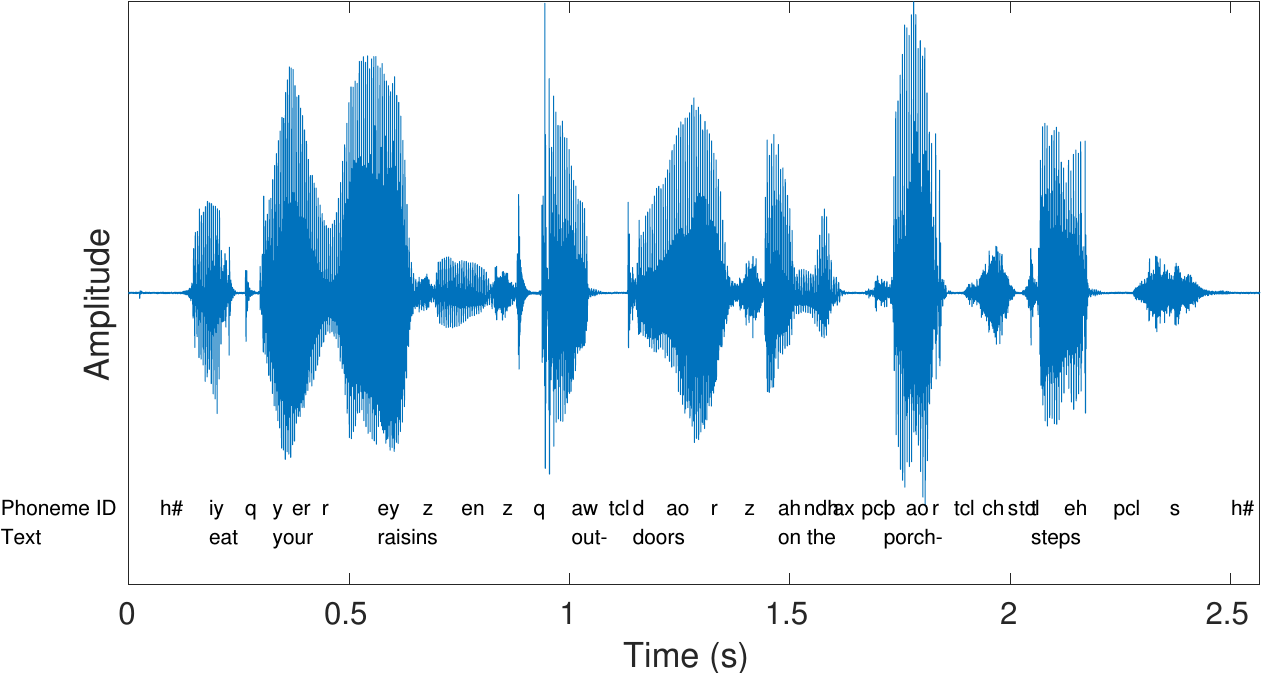

When learning with audio, it is often useful to pre-process the audio input before feeding it into the model. Why?

There are several reasons why that could be the case. Here are a few that are relevant to IDL Homeworks:
- **To learn with dense features**: The  $ T \times 1$ ends up being of very **high dimensionality**. For a 2 second utterance sampled at 16kHz, $ T = 16 \times 10^3 \times 2 = 32,000$. It is sometimes desirable to compute features from the raw audio that are more information dense than the audio itself.
- **Augmenting** the dataset to:
  - make the model more robust to challenging cases that might be expected at inference time
  - artificially expand the dataset

There are many other reasons that necessitate data preprocessing.




## Extracting Features: MFCCs
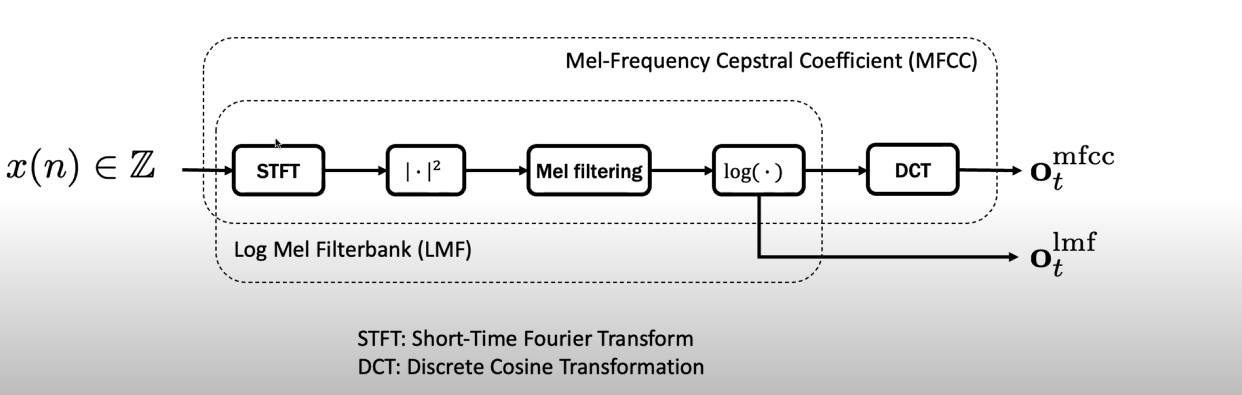

In the homeworks you will come across, the audio datasets will be provided as MFCCs. We will briefly go over the process of extracting MFCCs, but you will not be required to do this during the course.

In [ ]:
# data loading
import os
import numpy as np
import torch
import torchaudio
import librosa
import librosa.display
import IPython
import IPython.display
import matplotlib.pyplot as plt
import torchaudio.transforms as tat

In [ ]:
!rm *.flac*
# Download some audio files from the LibriSpeech dataset
base_url = "https://dagshub.com/DagsHub/Librispeech-ASR-corpus/raw/2fead768d9690a42d186188ed77a6d4c63c949dd/test-clean/8230/279154/8230-279154-000"
for i in range(4):
    # only take 1 and 2
    if i not in [1, 2]:
        continue
    file_url = f"{base_url}{i}.flac"
    !wget {file_url}


--2024-08-04 16:20:11--  https://dagshub.com/DagsHub/Librispeech-ASR-corpus/raw/2fead768d9690a42d186188ed77a6d4c63c949dd/test-clean/8230/279154/8230-279154-0001.flac
Resolving dagshub.com (dagshub.com)... 35.186.200.224
Connecting to dagshub.com (dagshub.com)|35.186.200.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘8230-279154-0001.flac’

8230-279154-0001.fl     [ <=>                ] 300.04K  --.-KB/s    in 0.008s  

2024-08-04 16:20:12 (37.6 MB/s) - ‘8230-279154-0001.flac’ saved [307246]

--2024-08-04 16:20:12--  https://dagshub.com/DagsHub/Librispeech-ASR-corpus/raw/2fead768d9690a42d186188ed77a6d4c63c949dd/test-clean/8230/279154/8230-279154-0002.flac
Resolving dagshub.com (dagshub.com)... 35.186.200.224
Connecting to dagshub.com (dagshub.com)|35.186.200.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘8230-279154-0002.flac

In [ ]:
# Save the path to the downloaded file
audio_path = "/content/8230-279154-0002.flac"

In [ ]:
# Play the file
IPython.display.Audio(audio_path)

Waveform shape: (263600,)
Sample rate: 16000
Audio length (seconds): 16.475


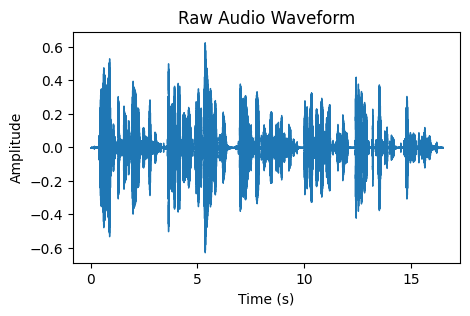

In [ ]:
# Load the audio file into the and get basic info
waveform, sample_rate = librosa.load(audio_path, sr=None)  # sr=None to keep original sample rate

# Get shape and sample rate
print(f"Waveform shape: {waveform.shape}") #Tells you how many audio samples are in the signal
print(f"Sample rate: {sample_rate}") #Shows how many data points per second are used to digitally represent the audio

# Get length of the audio in seconds
audio_length_seconds = len(waveform) / sample_rate  #Finds the duration of the audio in seconds.
print(f"Audio length (seconds): {audio_length_seconds}")

# Visualize the raw audio waveform
plt.figure(figsize=(5, 3))
librosa.display.waveshow(waveform, sr=sample_rate)
plt.title('Raw Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Mel Spectrogram:
This is a representation of the audio’s energy at various time and frequency bins, using the Mel scale for frequency. It still reflects a detailed “picture” of how energy is distributed across frequencies that matter to human hearing.

Mel Spectrogram:

Used for Visualization and Analysis:
Provides a rich, interpretable visualization of the audio’s content over time and frequency.

Base for Other Features:
Many downstream features (like MFCCs) are computed from the mel spectrogram.

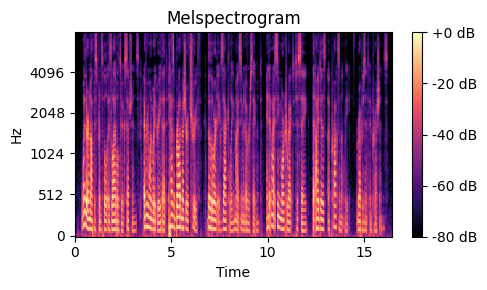

In [ ]:
# Convert raw audio --> melspectrogram
S = librosa.feature.melspectrogram(y=waveform, sr=sample_rate) #
S_dB = librosa.power_to_db(S, ref=np.max) #The spectrogram values, originally energy or power, are converted to decibel (dB) scale
# This makes the values easier to interpret visually and aligns better with human perception, as we perceive volume changes on a logarithmic scale.

# Visualize the melspectrogram
def plot_melspectrogram(S_dB, sample_rate, title="Melspectrogram"):
    plt.figure(figsize=(5, 3))
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_melspectrogram(S_dB, sample_rate)

MFCCs (Mel-Frequency Cepstral Coefficients):
These are further-processed features derived from the mel spectrogram by applying a Discrete Cosine Transform (DCT) to compress and decorrelate the information. MFCCs summarize the spectral envelope in a compact way, leading to features that are highly effective for speech and audio tasks.


MFCCs:

Compact Feature Representation:
MFCCs reduce the dimensionality and redundancy of the mel spectrogram, yielding a set of coefficients that summarize each timestep.


Better for ML Models:
These are more “dense” and robust features, less sensitive to non-relevant variance, making them ideal for feeding into machine learning models.

MFCC shape: (14, 515)


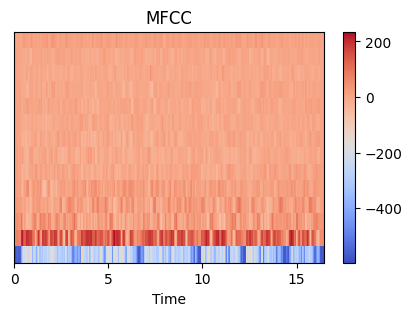

In [ ]:
# Convert raw audio --> mel-frequency cepstral coefficients (MFCC)
mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=14) # Converts a raw audio signal (waveform) into a set of MFCC features.

# print shape
print(f"MFCC shape: {mfccs.shape}") # Displays the dimensions of the MFCC feature matrix.

# Visualize the MFCC
plt.figure(figsize=(5, 3))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

## Cepstral Normalization
A process of scaling the MFCCs so that they have a mean of zero and a standard deviation of one. This standardization technique makes sure that the MFCCs are not dominated by some particular part of the spectrum and that all features contribute equally to the analysis.
This has several potential benefits:
 - reduction of noise impact
 - better robustness across environments
 - enhancement of feature discriminability

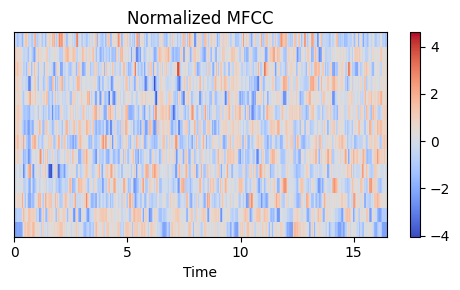

In [ ]:
# Apply normalization
mfccs_normalized = (mfccs - mfccs.mean(axis=1, keepdims=True)) / (mfccs.std(axis=1, keepdims=True) + 1e-5) #1e-5 is added to the denominator to avoid division by zero.

# Visualize MFCCs after cepstral normalization
plt.figure(figsize=(5, 3))
librosa.display.specshow(mfccs_normalized, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('Normalized MFCC')
plt.tight_layout()
plt.show()

## Augmentations for MFCCs
These are motivated by the SpecAugment paper.
The objectives are to:
- reducing overfitting
- improve robustness to deformations in the time direction, partial loss of frequency information and partial loss of small segments of
speech

### Time masking

parameters:
-  **time_mask_param**: maximum possible length of the mask. Indices uniformly sampled from  [0, time_mask_param).
- **iid_masks**: whether to apply different masks to each example/channel in the batch.
- **p**:maximum proportion of time steps that can be masked. Must be within range [0.0, 1.0]

Text(0.5, 1.0, 'Time-Masked MFCC')

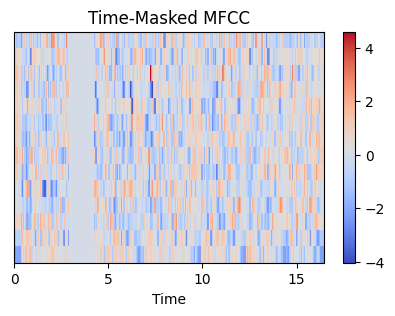

In [ ]:
time_mask = tat.TimeMasking(time_mask_param=100, p=0.2)
#time_mask_param=100: The maximum possible length (in frames) for a mask applied along the time axis of the MFCCs.
#p=0.2: The probability or proportion of the time axis that can be masked in each application (20%).
time_masked_mfcc = time_mask(torch.tensor(mfccs_normalized))
# plot
plt.figure(figsize=(5, 3))
librosa.display.specshow(time_masked_mfcc.numpy(), sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('Time-Masked MFCC')

### Frequency masking
parameters:
-  **freq_mask_param**: maximum possible length of the mask. Indices uniformly sampled from [0, freq_mask_param).
- **iid_masks**: whether to apply different masks to each example/channel in the batch

Text(0.5, 1.0, 'Frequency-Masked MFCC')

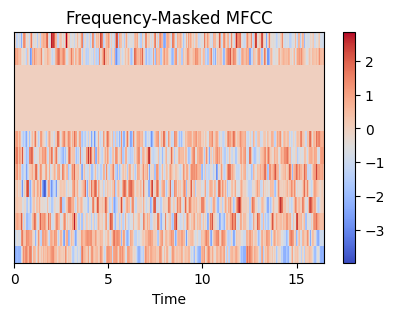

In [ ]:
freq_mask = tat.FrequencyMasking(freq_mask_param=5) #sets the maximum possible width (number of frequency bins) for the frequency mask applied to the MFCC features.
freq_masked_mfcc = freq_mask(torch.tensor(mfccs_normalized))
# plot
plt.figure(figsize=(5, 3))
librosa.display.specshow(freq_masked_mfcc.numpy(), sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('Frequency-Masked MFCC')

Augmentations on a mini-batch

In [ ]:
import glob
audio_files = glob.glob('/content/8230-279154-000*.flac') #finding all the file paths that match this specified pattern.
print(audio_files)

['/content/8230-279154-0002.flac', '/content/8230-279154-0001.flac']


The next code block processes a batch of audio files to extract and visualize their MFCC (Mel-Frequency Cepstral Coefficient) features in a standardized, comparative way.

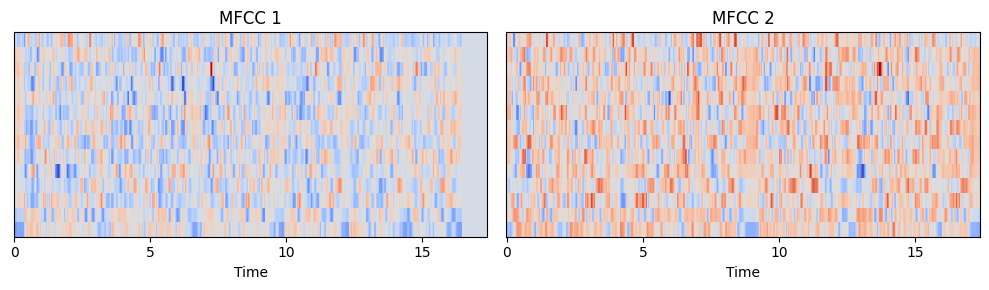

In [ ]:
# load all audio files
waveforms = []
for audio_file in audio_files:
    waveform, sample_rate = librosa.load(audio_file, sr=None)
    waveforms.append(waveform)

# Compute MFCCs
mfccs_batch = []
for waveform in waveforms:
    mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=14)
    # normalize them
    mfcc = (mfcc - mfcc.mean(axis=1, keepdims=True)) / (mfcc.std(axis=1, keepdims=True) + 1e-5)
    mfccs_batch.append(mfcc)

# Pad MFCCs to the same length
max_length = max(mfcc.shape[1] for mfcc in mfccs_batch)
padded_mfccs_batch = [np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant') for mfcc in mfccs_batch]

# Plot as a 2 by 2 grid
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.flatten()

for i, mfcc in enumerate(padded_mfccs_batch):
    if i < 4:  # Ensure there are only 4 plots
        ax = axes[i]
        librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time', ax=ax)
        ax.set_title(f'MFCC {i+1}')

plt.tight_layout()
plt.show()

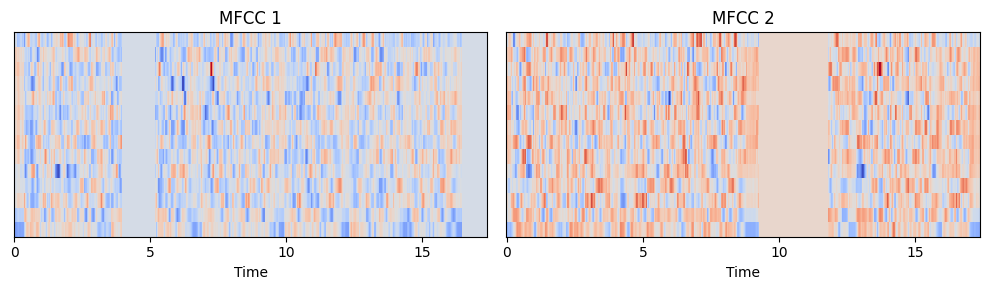

In [ ]:
# time masking in a batch with IID mask = true
time_mask = tat.TimeMasking(time_mask_param=100, iid_masks=True, p=0.8)
time_masked_mfccs_batch = time_mask(torch.tensor(padded_mfccs_batch))
# plot
# Plot as a 2 by 2 grid
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.flatten()

for i, mfcc in enumerate(time_masked_mfccs_batch):
    if i < 4:  # Ensure there are only 4 plots
        ax = axes[i]
        librosa.display.specshow(mfcc.numpy(), sr=sample_rate, x_axis='time', ax=ax)
        ax.set_title(f'MFCC {i+1}')

plt.tight_layout()
plt.show()

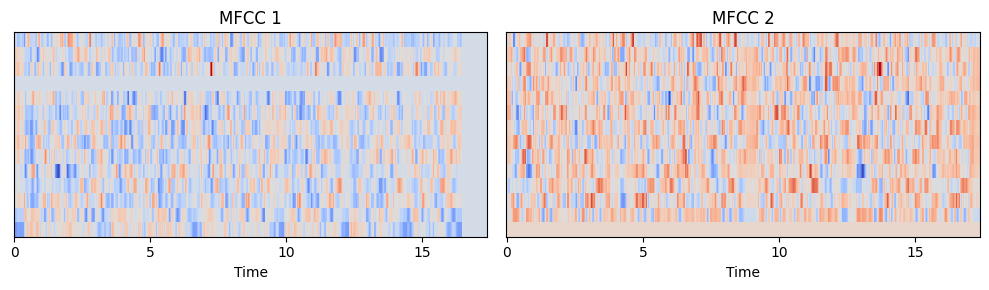

In [ ]:
# frequency masking with IID = true
freq_mask = tat.FrequencyMasking(freq_mask_param=4, iid_masks=True)
freq_masked_mfccs_batch = freq_mask(torch.tensor(padded_mfccs_batch))
# plot
# Plot as a 2 by 2 grid
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes = axes.flatten()

for i, mfcc in enumerate(freq_masked_mfccs_batch):
    if i < 4:  # Ensure there are only 4 plots
        ax = axes[i]
        librosa.display.specshow(mfcc.numpy(), sr=sample_rate, x_axis='time', ax=ax)
        ax.set_title(f'MFCC {i+1}')

plt.tight_layout()
plt.show()